# DF: My experiments with sorting and edge sampling

### These include data visualization and other experiments

In [67]:
import time
import os
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, LeakyReLU, Dropout, BatchNorm1d
from torch.nn.functional import gumbel_softmax
import pickle
import numpy as np
import networkx as nx
import pandas as pd
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [68]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cpu


In [69]:
#DF18-01: add device for GPU
device = 'cpu'
print(device)

cpu


## Table of Contents <a class="anchor" id="toc"></a>
* [Global variables](#variables)
* [Model](#model)
    * [Discriminator](#discriminator)
    * [Generator](#generator)
    * [DAG](#dag)
* [Dataset](#data)
* [Visualization](#visualization)
* [Instantiation](#instantiation)
* [Training](#training)
* [End](#end)

## Global variables <a class="anchor" id="variables"></a>

In [70]:
data_sample_size = 5000
data_variable_size = 10
x_dims =1
z_dims =1
code_dims =1
graph_type = 'erdos-renyi'
graph_degree = 3
graph_sem_type = 'linear-gauss'
graph_linear_type = 'nonlinear_1'
graph_threshold =0.3

batch_size=200                     #40
lr = 8e-3                          #3e-3: tried 6e-3, 4e-3 ######AM_11/8 8e-3 shows loss almost better
es = 30                            #DF11_01: add es to control the lr scale , was 30, tried 50
negative_slope = 0.2
dropout_rate = 0.4                 #was 0.5 ####AM 0.4

seed=42
epochs =800
discriminator_steps = 4             #5,10 and 5 was really good
ScaleA=10                           #DF08-01: set this to 1 for debug, was 40

synthesize=0
####fname1=f"data/train_loader2023-01-10 10=13.pkl"   #DF10-1: from 12=45, we do not save this anymore

#fname2=f"data/ground_truth_G2023-01-10 12=45.pkl"
#fname3=f"data/X_data_exp2023-01-10 12=45.csv"
fname2=f"/content/results/data/ground_truth_G2023-08-09 22=15.pkl"
fname3=f"/content/results/data/X_data_exp2023-08-09 22=15.csv"

disp_order_within_epoch=0           #DF06-01:control whether to display the node order within an epoch

#DF16-01: add schedulers parameters
lr_decay = 120 #####
gamma=0.2

## The Model <a class="anchor" id="model"></a>

* [Back to ToC](#toc)

### The discriminator <a class="anchor" id="discriminator"></a>

In [71]:
class Discriminator(nn.Module):
    """Discriminator module."""
    def __init__(self, input_dim, discriminator_dim, negative_slope, dropout_rate, pac=10):
        super(Discriminator, self).__init__()
        dim = input_dim * pac
        self.pac = pac
        self.pacdim = dim

        seq = []
        for item in list(discriminator_dim):
            seq += [Linear(dim, item), LeakyReLU(negative_slope), Dropout(dropout_rate)]
            dim = item

        seq += [Linear(dim, 1)]
        self.seq = Sequential(*seq)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.0)
            elif isinstance(m, BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def calc_gradient_penalty(self, real_data, fake_data, device='cpu', pac=10, lambda_=10):

        # reshape data
        real_data = real_data.squeeze()
        fake_data = fake_data.squeeze()

        alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
        alpha = alpha.repeat(1, pac, real_data.size(1))
        alpha = alpha.view(-1, real_data.size(1))

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        disc_interpolates = self(interpolates)

        gradients = torch.autograd.grad(
            outputs=disc_interpolates, inputs=interpolates,
            grad_outputs=torch.ones(disc_interpolates.size(), device=device),
            create_graph=True, retain_graph=True, only_inputs=True
        )[0]

        gradient_penalty = ((
            gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1
        ) ** 2).mean() * lambda_

        return gradient_penalty

    def forward(self, input):
        assert input.size()[0] % self.pac == 0
        return self.seq(input.view(-1, self.pacdim))

### The Generator <a class="anchor" id="generator"></a>

* [Back to ToC](#toc)

In [72]:

def order_nodes(P_inv):   #This is the code from Hristo

    P_inv = P_inv.clone().detach().cpu().numpy() # might be here

    m = np.arange(1, P_inv.shape[0] + 1)
    m = np.array(m)

    #array for ordering
    order = np.zeros_like(P_inv)

    for num in reversed(range(P_inv.shape[0])):
        order[num] = P_inv[:,num] * m
    order = order[order != 0][::-1] #gives a list of ordered nodes in reversed order
    return order

class Generator(nn.Module):
    """Generator module (based on DAG-NotearsMLP)"""
    def __init__(self, m, k, dims, bias=True):
        super(Generator, self).__init__()
        assert len(dims) >= 2
        assert dims[-1] == 1

        self.input_dims = dims[0]
        self.hidden_dims = dims[1:-1]
        self.output_dim = dims[-1]


        # fc1: local linear layers
        #DF08-01: this is used by additive noise model as well
        #"""
        #DF: reconstrucntion (without z)
        self.fc1 =  nn.ModuleList([self.linear_sequential(input_dims=self.input_dims,
                                                          hidden_dims=self.hidden_dims,
                                                          output_dim=self.output_dim) for i in range(data_variable_size)])
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.0)
            elif isinstance(m, BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def linear_sequential(self, input_dims, hidden_dims, output_dim):
        dims = [np.prod(input_dims)] + hidden_dims + [output_dim]
        num_layers = len(dims) - 1

        layers = []
        for i in range(num_layers):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < num_layers - 1:
                layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    #"""
    #DF08-01: experiment with additive noise
    def forward(self, z, n, d, A, P_inv):  # [n, d] -> [n, d]

        #DF18-01: add device for GPU
        pred_X = torch.zeros([n, d]).double().to(device) #x_dims = 1

        ordered_vertices = order_nodes(P_inv)
        assert len(ordered_vertices) == d

        #DF expriment: try to use either order
        #The nodes are 1,2,3, where 3 is the top parent,
        # We get [3,2,1] in ordered_vertices,
        for i in range(self.input_dims):             #for Approach 1

            current_node = int(ordered_vertices[i])
            masked_X = pred_X.clone() * A[current_node-1,:].unsqueeze(0) *ScaleA #DF try to scale up the mask
            pred_X[:, current_node-1] = self.fc1[current_node - 1](masked_X).squeeze() +z[:, current_node-1, :].squeeze()

        return pred_X
    #"""

### The DAG <a class="anchor" id="dag"></a>

* [Back to ToC](#toc)

In [73]:
def sofsorting(X, nsize):

    #get the data ready
    X = X.unsqueeze(0)
    X = X.unsqueeze(-1)

    #soft sorting with pairwise diff
    X_sorted = X.sort(descending=True, dim=1)[0]
    X_id     = X.sort(descending=True, dim=1)[1]

    pairwise_diff = (X.transpose(1, 2) - X_sorted).abs().neg() / 1.0
    P_hat = pairwise_diff.softmax(-1)

    #compute permutation matrix (P_hat) from softmax(pairwise_diff)
    P = torch.zeros_like(P_hat)
    P.scatter_(-1, P_hat.topk(1, -1)[1], value=1)
    P_hat = (P - P_hat).detach() + P_hat

    #compute Order from P_hat
    m = np.arange(1, nsize + 1)
    mt = torch.from_numpy(m)
    order = torch.zeros(nsize)

    P_hat = P_hat.squeeze()
    for num in range(nsize):
        order[num] = sum(P_hat[num,:]*mt) -1

    return order

In [74]:
class SoftSort_p1(torch.nn.Module):
    def __init__(self, tau=1.0, hard=False):
        super(SoftSort_p1, self).__init__()
        self.hard = hard
        self.tau = tau

    def forward(self, scores: Tensor):
        """
        scores: elements to be sorted. Typical shape: batch_size x n
        """
        scores = scores.unsqueeze(-1)
        sorted = scores.sort(descending=True, dim=1)[0]
        pairwise_diff = (scores.transpose(1, 2) - sorted).abs().neg() / self.tau
        P_hat = pairwise_diff.softmax(-1)

        if self.hard:
            P = torch.zeros_like(P_hat, device=P_hat.device)
            P.scatter_(-1, P_hat.topk(1, -1)[1], value=1)
            P_hat = (P - P_hat).detach() + P_hat


        return P_hat

class ProbabilisticDAG(nn.Module):

    def __init__(self, n_nodes, temperature=1.0, hard=True, order_type='sinkhorn', noise_factor=1.0, initial_adj=None, lr=1e-3, seed=42):
        """Base Class for Probabilistic DAG Generator based on topological order sampling

        Args:
            n_nodes (int): Number of nodes
            temperature (float, optional): Temperature parameter for order sampling. Defaults to 1.0.
            hard (bool, optional): If True output hard DAG. Defaults to True.
            order_type (string, optional): Type of differentiable sorting. Defaults to 'sinkhorn'.
            noise_factor (float, optional): Noise factor for Sinkhorn sorting. Defaults to 1.0.
            initial_adj (torch.tensor, optional): Initial binary adjecency matrix from e.g. PNS.
                Edges with value 0 will not be learnt in further process Defaults to None.
            lr (float, optional): Learning rate. Defaults to 1e-3.
            seed (int, optional): Random seed. Defaults to 0.
        """
        super().__init__()

        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        self.n_nodes = n_nodes
        self.temperature = temperature
        self.hard = hard
        self.order_type = order_type

        # Mask for ordering (a completed DAG)
        self.mask = torch.triu(torch.ones(self.n_nodes, self.n_nodes, device=device), 1)

        # define initial parameters
        if self.order_type == 'sinkhorn':
            self.noise_factor = noise_factor
            p = torch.zeros(n_nodes, n_nodes, requires_grad=True, device=device)
            self.perm_weights = torch.nn.Parameter(p)
        elif self.order_type == 'topk':
            p = torch.zeros(n_nodes, requires_grad=True, device=device)
            self.perm_weights = torch.nn.Parameter(p)
            self.sort = SoftSort_p1(hard=self.hard, tau=self.temperature)
        else:
            raise NotImplementedError

        e = torch.zeros(n_nodes, n_nodes, requires_grad=True, device=device)
        torch.nn.init.uniform_(e)
        if initial_adj is not None:
            initial_adj = initial_adj.to(device)
            zero_indices = (1 - initial_adj).bool()
            # set masked edges to zero probability
            e.requires_grad = False
            e[zero_indices] = -300
            e.requires_grad = True

        #DF change
        #torch.diagonal(e).fill_(-300) #this line crashes, fix is below
        torch.diagonal(e).data.fill_(-300)

        self.edge_log_params = torch.nn.Parameter(e)

        if initial_adj is not None:
            self.edge_log_params.register_hook(lambda grad: grad * initial_adj.float())

        #self.lr = lr
        #self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.0)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def sample_edges(self):
        p_log = F.logsigmoid(torch.stack((self.edge_log_params, -self.edge_log_params)))
        dag = gumbel_softmax(p_log, hard=True, dim=0)[0]

        return dag

    def sample_permutation(self):
        if self.order_type == 'sinkhorn':
            log_alpha = F.logsigmoid(self.perm_weights)
            P, _ = gumbel_sinkhorn(log_alpha, noise_factor=self.noise_factor, temp=self.temperature, hard=self.hard)
            P = P.squeeze().to(device)
        elif self.order_type == 'topk':
            logits = F.log_softmax(self.perm_weights, dim=0).view(1, -1)
            gumbels = -torch.empty_like(logits).exponential_().log()
            gumbels = (logits + gumbels) / 1

            P = self.sort(gumbels)
            P = P.squeeze()

        else:
            raise NotImplementedError
        return P

    def sample(self):
        P = self.sample_permutation()
        P_inv = P.transpose(0, 1)
        dag_adj = self.sample_edges()
        dag_adj = dag_adj * torch.matmul(torch.matmul(P_inv, self.mask), P)  # apply autoregressive masking
        return dag_adj , P_inv

    def log_prob(self, dag_adj):
        raise NotImplementedError

    def deterministic_permutation(self, hard=True):
        if self.order_type == 'sinkhorn':
            log_alpha = F.logsigmoid(self.perm_weights)
            P, _ = gumbel_sinkhorn(log_alpha, temp=self.temperature, hard=hard, noise_factor=0)
            P = P.squeeze().to(device)
        elif self.order_type == 'topk':
            sort = SoftSort_p1(hard=hard, tau=self.temperature)
            P = sort(self.perm_weights.detach().view(1, -1))
            P = P.squeeze()
        return P

    def get_threshold_mask(self, threshold):
        P = self.deterministic_permutation()
        P_inv = P.transpose(0, 1)
        dag = (torch.sigmoid(self.edge_log_params.detach()) > threshold).float()
        dag = dag * torch.matmul(torch.matmul(P_inv, self.mask), P)  # apply autoregressive masking
        return dag

    def get_prob_mask(self):
        P = self.deterministic_permutation()
        P_inv = P.transpose(0, 1)
        e = torch.sigmoid(self.edge_log_params.detach())
        e = e * torch.matmul(torch.matmul(P_inv, self.mask), P)  # apply autoregressive masking
        return e

    def print_parameters(self, prob=True):
        print('Permutation Weights')
        print(torch.sigmoid(self.perm_weights) if prob else self.perm_weights)
        print('Edge Probs')
        print(torch.sigmoid(self.edge_log_params) if prob else self.edge_log_params)


## The Dataset <a class="anchor" id="data"></a>

* [Back to ToC](#toc)

In [75]:
#A standard process to convert data to loaders
def data_to_tensor_dataset(X, batch_size, G=None):

    feat_train = torch.FloatTensor(X)
    train_data = TensorDataset(feat_train, feat_train)
    train_data_loader = DataLoader(train_data, batch_size=batch_size)

    return train_data_loader, G

In [76]:
#A standard process to generate a random dag
def simulate_random_dag(d: int,
                        degree: float,
                        graph_type: str,
                        w_range: tuple = (0.5, 2.0)) -> nx.DiGraph:
    """Simulate random DAG with some expected degree.
    Args:
        d: number of nodes
        degree: expected node degree, in + out
        graph_type: {erdos-renyi, barabasi-albert, full}
        w_range: weight range +/- (low, high)
    Returns:
        G: weighted DAG
    """
    if graph_type == 'erdos-renyi':
        prob = float(degree) / (d - 1)
        B = np.tril((np.random.rand(d, d) < prob).astype(float), k=-1)
    elif graph_type == 'barabasi-albert':
        m = int(round(degree / 2))
        B = np.zeros([d, d])
        bag = [0]
        for ii in range(1, d):
            dest = np.random.choice(bag, size=m)
            for jj in dest:
                B[ii, jj] = 1
            bag.append(ii)
            bag.extend(dest)
    elif graph_type == 'full':  # ignore degree, only for experimental use
        B = np.tril(np.ones([d, d]), k=-1)
    else:
        raise ValueError('unknown graph type')
    # random permutation
    P = np.random.permutation(np.eye(d, d))  # permutes first axis only
    B_perm = P.T.dot(B).dot(P)
    U = np.random.uniform(low=w_range[0], high=w_range[1], size=[d, d])
    U[np.random.rand(d, d) < 0.5] *= -1
    W = (B_perm != 0).astype(float) * U
    G = nx.DiGraph(W)
    return G

In [77]:
#DF: this is my version of synthetic data, which creates the data from A
def simulate_sem_DF(G: nx.DiGraph,
                 n: int, x_dims: int,
                 sem_type: str,
                 linear_type: str,
                 noise_scale: float = 1.0) -> np.ndarray:
    """Simulate samples from SEM with specified type of noise.
    Args:
        G: weigthed DAG
        n: number of samples
        sem_type: {linear-gauss,linear-exp,linear-gumbel}
        noise_scale: scale parameter of noise distribution in linear SEM
    Returns:
        X: [n,d] sample matrix
    """

    ###masked_X = pred_X.clone() * A[current_node-1,:].unsqueeze(0)

    W = nx.to_numpy_array(G)
    W = np.abs(W.T)                          #DF: nx is colum based, hence we need to change it to row based, also remove negative
    print("Ground truth: W\n", np.around(W,1))

    d = W.shape[0]
    X = np.zeros([n, d, x_dims])
    ordered_vertices = list(nx.topological_sort(G))
    assert len(ordered_vertices) == d
    #print("ordered_vertices",ordered_vertices)
    for j in ordered_vertices:
        parents = list(G.predecessors(j))
        if linear_type == 'linear':
            X[:,j,:] = np.sum(X * W[j,:]) + np.random.normal(scale=noise_scale, size=n)
        elif linear_type == 'nonlinear_1':
            weighted = np.cos(X+1).squeeze() * W[j,:]

            sum1 = np.sum(weighted, axis=1)
            sum2 = sum1+np.random.normal(scale=1.0, size=n)*1.0  #1e-01    #was 1.0

            #######################################print("sum2+shape",sum2[..., np.newaxis].shape)  #[5000,1]
            X[:,j,:] = sum2[..., np.newaxis]

            ######################X[:,j,:] = np.sum(np.cos(X+1).squeeze() * W[j,:],axis=1)
            ######################X[:,j,:] = np.sum(np.cos(X+1) * W[j,:]) #+ np.random.normal(scale=noise_scale, size=n)
        elif linear_type == 'nonlinear_2':
            X[:,j,:] = np.sum(2*np.sin((X+0.5) * W[j,:]) + (X+0.5)*W[j,:]) + np.random.normal(scale=noise_scale, size=n)

    return X, ordered_vertices   #DF06-01: add for visualizing the node order


In [78]:
def load_data():
    ## configurations
    n, d = data_sample_size, data_variable_size

    G = simulate_random_dag(d, graph_degree, graph_type)

    X, order = simulate_sem_DF(G, n, x_dims, graph_sem_type, graph_linear_type)

    train_data_loader, G = data_to_tensor_dataset(X, batch_size, G)

    return train_data_loader, G, X, order  #DF06-01: add X and order for visualization

In [79]:
#DF10-01: Here we save/read the CSV and the graph files only (not the loader) to allow batch size change
if synthesize:
    #create and store synthetic data
    train_loader, ground_truth_G, X_data, X_order = load_data()

    #DF10-01: save them
    #t = time.strftime('%Y-%m-%d %H=%M=%S', time.localtime())
    t = time.strftime('%Y-%m-%d %H=%M', time.localtime())
    fname2 = f"data/ground_truth_G" + str(t) + ".pkl"
    fname3 = f"data/X_data_exp"     + str(t) + ".csv"  #DF10-01: add fname3
    with open(fname2, "wb") as output_file_G:
        pickle.dump(ground_truth_G, output_file_G)
    pd.DataFrame(X_data.squeeze()).to_csv(fname3)

else:
    #DF10-01: read the graph data
    with open(fname2, "rb") as input_file_G:
        ground_truth_G = pickle.load(input_file_G)

    #DF10-01: read the csv data
    X_data = pd.read_csv(fname3, header=None)
    X_data = X_data.to_numpy()
    X_data = np.delete(X_data, np.s_[0], axis=0) #DF: remove first row
    X_data = np.delete(X_data, np.s_[0], axis=1) #DF: remove first column
    X_data = X_data[...,np.newaxis]
    #print("X_data", X_data.shape, "\n", X_data)

    #DF10-01: create the loader
    train_loader, G = data_to_tensor_dataset(X_data, batch_size, ground_truth_G)

    #DF10-01; create the order
    X_order = list(nx.topological_sort(ground_truth_G))
    assert len(X_order) == data_variable_size

print("X_order",X_order)

X_order [8, 6, 7, 3, 2, 5, 1, 0, 9, 4]


## Visualization function<a class="anchor" id="visualization"></a>

* [Back to ToC](#toc)

In [80]:
#DF06-01 added a visualization function
def Visualize_data(X, variable_size, sampling=0, fname="data"):

    plt.ioff()  # Turn interactive plotting off

    fig, axs = plt.subplots(variable_size)
    fig.suptitle('Data distributions')
    fig.set_figheight(5)
    fig.set_figwidth(1)

    if sampling==0: #visualize the entire dataset
        for i in range(variable_size):
            axs[i].hist(X[:,i,:], bins=50)
            axs[i].set(ylabel='X'+str(i))
    else:      #visualize sampled data
        sample = np.random.uniform(size=5000)*data_sample_size
        sample = sample.astype(int)

        for i in range(data_variable_size):
            axs[i].hist(X[sample,i,:], bins=50)
            axs[i].set(ylabel='X'+str(i))

    plt.close(fig) #don't display
    #fig.show()
    fig.savefig(fname, bbox_inches = 'tight')


print("the order of the nodes:",X_order)
Visualize_data(X_data, data_variable_size, sampling=0, fname="results/data") #DF10-01: save data to the result folder
#Visualize_data(X_data, data_variable_size, sampling=1, fname="sampled_data")

the order of the nodes: [8, 6, 7, 3, 2, 5, 1, 0, 9, 4]


In [81]:
#DF08-01 visualize conditional distributions
def Visualize_conditional_distribution(X, variable_size, condition, target, bin_values, fname="condition_data"):
#DF: target is a single index in X[]; condition is a single index in X[]
#    bin_values[] an array of bins

    plt.ioff()  # Turn interactive plotting off
    bin_size = len(bin_values)

    fig, axs = plt.subplots(bin_size)
    fig.suptitle('conditional distributions')
    fig.set_figheight(5)
    fig.set_figwidth(1)

    for i in range(bin_size-1):
        rows = np.where((bin_values[i]<X[:,condition,:]) & (X[:,condition,:]<bin_values[i+1]))[0]

        axs[i].hist(X[rows,target,:], bins=10)
        axs[i].set(ylabel='Bin'+str(i))

    plt.close(fig) #don't display
    #fig.show()
    fig.savefig(fname, bbox_inches = 'tight')

In [82]:
#DF09-01: visualise the conditional distribution
"""
bin_values = np.arange(-2,2,0.2)
for j in range(data_variable_size):
    for i in range(j+1, data_variable_size):
        Visualize_conditional_distribution(X_data, data_variable_size, j,i, bin_values,
                                           fname="data_condition/condition_data"+str(j+1)+str(i+1))
        Visualize_conditional_distribution(X_data, data_variable_size, i,j, bin_values,
                                           fname="data_condition/condition_data"+str(i+1)+str(j+1))
"""

'\nbin_values = np.arange(-2,2,0.2)\nfor j in range(data_variable_size):\n    for i in range(j+1, data_variable_size):\n        Visualize_conditional_distribution(X_data, data_variable_size, j,i, bin_values,\n                                           fname="data_condition/condition_data"+str(j+1)+str(i+1))\n        Visualize_conditional_distribution(X_data, data_variable_size, i,j, bin_values,\n                                           fname="data_condition/condition_data"+str(i+1)+str(j+1))\n'

## Instantiation <a class="anchor" id="instantiation"></a>

* [Back to ToC](#toc)

In [83]:
#DF18-01: add to device for GPU
discriminator = Discriminator(data_variable_size, (256, 256), negative_slope, dropout_rate).double().to(device) #.to(self.device)
#DF tried different Generator layers
generator = Generator(z_dims, code_dims, dims=[data_variable_size, 10, 10, 10, 1], bias=True).double().to(device) #.to(self.device)
#generator = Generator(self.z_dims, self.code_dim, dims=[self.data_variable_size, 10, 10, 1], bias=True).double().to(self.devic
#DF modi: experiment with a different order_type
dp_dag = ProbabilisticDAG(n_nodes=data_variable_size, order_type='topk', initial_adj=None, seed=seed).to(device) #.to(self.device)
#dp_dag = ProbabilisticDAG(n_nodes=self.data_variable_size, order_type='sinkhorn', initial_adj=None, seed=self.seed).to(self.device)

In [84]:
#optimizer = torch.optim.Adam([X], lr=1e-01)
#optimizer.zero_grad()

optimizerD   = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9), weight_decay=1e-6)
#DF16-01: change according to the suggestions by Hristo
#optimizerG   = torch.optim.Adam(generator.parameters(), lr=lr)
optimizerG   = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9), weight_decay=1e-6)
optimizerDAG = torch.optim.Adam(dp_dag.parameters(), lr=lr*es)  #DF reduce lr for DAG 0.00001 #DF_11_01 use es

In [85]:
#DF16-01: add schedulers
#schedulerG   = lr_scheduler.StepLR(optimizerG,   step_size=lr_decay, gamma=gamma)
#schedulerD   = lr_scheduler.StepLR(optimizerD,   step_size=lr_decay, gamma=gamma)
#schedulerDAG = lr_scheduler.StepLR(optimizerDAG, step_size=lr_decay, gamma=gamma)

schedulerG   = lr_scheduler.CosineAnnealingLR(optimizerG,   200)
schedulerD   = lr_scheduler.CosineAnnealingLR(optimizerD,   200)
schedulerDAG = lr_scheduler.CosineAnnealingLR(optimizerDAG, 200)

## Training <a class="anchor" id="training"></a>

* [Back to ToC](#toc)

In [86]:
def fake_data_generation(size):
    #DF18-01: add to device for GPU
    #z = Variable(torch.FloatTensor(np.random.normal(0, 1, (self.batch_size, self.data_variable_size, self.z_dims)))).double().cuda()
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (size, data_variable_size, z_dims)))).double().to(device)
    A, P_inv = dp_dag.sample()

    fake_data = generator(z, size, data_variable_size, A, P_inv)
    return fake_data

#DF: this is the my implementation "train", where I do not repeat the same data with self.discriminator_steps
'''training algorithm for a single epoch'''
def train_DF(train_loader, epoch, ground_truth_G, optimizerG, optimizerD, optimizerDAG):

    t = time.time()
    D_loss = []
    G_loss = []
    Pen_loss = []
    #MMD_loss = [] #DF remove
    mse_train = []
    shd_trian = []

    # update optimizer
    #optimizerG, lr = self.update_optimizer(optimizerG, self.lr, c_A)
    #optimizerD, lr = self.update_optimizer(optimizerD, self.lr, c_A)

    N_Dag_updated = 0                            #DF added

    for batch_idx, (data, relations) in enumerate(train_loader):
        ###################################################################
        # (1) Update D network: maximize D(x)) - D(G(z)))
        ###################################################################

        data, relations = Variable(data.to(device)).double(), Variable(relations.to(device)).double()

        #DF07-01: Added visualization of real data at the first batch of certain epoches
        #if batch_idx==0 and epoch%10==0:
        #    Visualize_data(data, data_variable_size, sampling=0, fname="results/real"+str(epoch))

        optimizerD.zero_grad()

        #DF07-01: modi added batch_size
        fake = fake_data_generation(batch_size)

        y_fake = discriminator(fake)
        y_real = discriminator(data)

        if x_dims > 1:
            #vector case
            pen = discriminator.calc_gradient_penalty(
                data.view(-1, data.size(1) * data.size(2)), fake.view(-1, fake.size(1) * fake.size(2)), device)
            loss_d = -(torch.mean(F.softplus(y_real)) - torch.mean(F.softplus(y_fake)))
        else:
            #normal continious and discrete data case
            pen = discriminator.calc_gradient_penalty(
                    data, fake, device)
            #DF modi: NO solftplus
            #loss_d = -(torch.mean(F.softplus(y_real)) - torch.mean(F.softplus(y_fake)))
            loss_d = -(torch.mean(y_real) - torch.mean(y_fake))

        Pen_loss.append(pen.item())
        pen.backward(retain_graph=True)

        D_loss.append(loss_d.item())
        loss_d.backward()
        loss_d = optimizerD.step()

        ###############################################
        # (2) Update G network: maximize log(D(G(z)))
        ###############################################
        if batch_idx % discriminator_steps == 0:

            optimizerG.zero_grad()
            optimizerDAG.zero_grad()

            #DF07-01: modi added batch_size
            fake = fake_data_generation(batch_size)
            y_fake = discriminator(fake)

            #DF remove
            #loss_mmd = compute_mmd(data.squeeze(), fake_data)

            #DF modi: add regularation
            #loss_g = -torch.mean(F.softplus(y_fake)) #+ loss_mmd
            kl_loss = torch.nn.KLDivLoss(reduction='mean')
            regularizer = kl_loss(dp_dag.edge_log_params, 0.01 * torch.ones_like(dp_dag.edge_log_params))
            #DF modi: NO solftplus
            #loss_g = -torch.mean(F.softplus(y_fake))+0.01*regularizer
            loss_g = -torch.mean(y_fake)+0.1*regularizer               #DF: was 0.01

            #print("-torch.mean(y_fake)",-torch.mean(y_fake))
            #print("regularizer", regularizer)

            G_loss.append(loss_g.item())
            #MMD_loss.append(loss_mmd.item())  #DF remove
            loss_g.backward()
            optimizerG.step()

            #DF modi: learn optimizerDAG less
            #optimizerDAG.step()
            NN = discriminator_steps * 1    #1 means the Dag and generators are updated together
            if batch_idx % NN == 0:
                optimizerDAG.step()

            ###############################################
            # (3) Update DAG network: maximize log(D(G(z)))
            ###############################################

            #DF remove
            #self.schedulerG.step()
            #self.schedulerD.step()
            #self.schedulerDAG.step()

            #print(self.dp_dag.weight.grad)

            graph = dp_dag.get_prob_mask().detach().cpu().numpy()
            graph[np.abs(graph) < graph_threshold] = 0

            if ground_truth_G != None:
                GAA = nx.adjacency_matrix(ground_truth_G)
                GAA = np.abs(GAA)       #DF: for GAA, we do not really use any negative entries
                GAA[GAA>0.01] = 1        #DF: binarises GAA
                #graph[np.abs(graph) >= self.graph_threshold] = 1  #DF: binarises the graph
                graph[graph >=  graph_threshold] =  1
                graph[graph <= -graph_threshold] = -1
                #fdr, tpr, fpr, shd, nnz = count_accuracy(ground_truth_G, nx.DiGraph(graph))
                fdr, tpr, fpr, shd, nnz = count_accuracy(nx.DiGraph(GAA), nx.DiGraph(graph.T))

                shd_trian.append(shd)   #shd is stored

            mse_train.append(F.mse_loss(fake, data.squeeze()).item())

    print('Epoch: {:04d}'.format(epoch),
              'D_loss: {:.10f}'.format(np.mean(D_loss)),
              'G_loss: {:.10f}'.format(np.mean(G_loss)),
              'Pen_loss: {:.10f}'.format(np.mean(Pen_loss)),
              #'MMD_loss: {:.10f}'.format(np.mean(MMD_loss)), #DF remove
              'mse_train: {:.10f}'.format(np.mean(mse_train)),
              'shd_trian: {:.10f}'.format(np.mean(shd_trian)),
              'time: {:.4f}s'.format(time.time() - t))

    #DF10-1: add return of shd_train
    return np.mean(D_loss), np.mean(G_loss), np.mean(Pen_loss), np.mean(mse_train), np.mean(shd_trian), graph

def count_accuracy(G_true: nx.DiGraph,
                   G: nx.DiGraph,
                   G_und: nx.DiGraph = None) -> tuple:
    """Compute FDR, TPR, and FPR for B, or optionally for CPDAG B + B_und.
    Args:
        G_true: ground truth graph
        G: predicted graph
        G_und: predicted undirected edges in CPDAG, asymmetric
    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """
    B_true = nx.to_numpy_array(G_true) != 0
    B = nx.to_numpy_array(G) != 0
    B_und = None if G_und is None else nx.to_numpy_array(G_und)
    d = B.shape[0]
    # linear index of nonzeros
    if B_und is not None:
        pred_und = np.flatnonzero(B_und)
    pred = np.flatnonzero(B)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    if B_und is not None:
        # treat undirected edge favorably
        true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
        true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    if B_und is not None:
        false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
        false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred)
    if B_und is not None:
        pred_size += len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    B_lower = np.tril(B + B.T)
    if B_und is not None:
        B_lower += np.tril(B_und + B_und.T)
    pred_lower = np.flatnonzero(B_lower)
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return fdr, tpr, fpr, shd, pred_size

def Visulize_results(epoch):
    #DF18-01: correction add cpu() for GPU
    fake = fake_data_generation(5000).detach().cpu().numpy()
    fake = fake[..., np.newaxis]
    Visualize_data(fake, data_variable_size, sampling=0, fname="results/fake"+str(epoch))

def print_results():

    graph = dp_dag.get_prob_mask().detach().cpu().numpy()
    GW = nx.to_numpy_array(ground_truth_G)
    GW = np.abs(GW)       #DF: for GAA, we do not really use any negative entries
    GW[GW>0.01] = 1        #DF: binarises GAA
    print("GW", np.around(GW.T,1))
    print("graph", np.around(graph,1))

    graph_th1 = np.array(graph)
    graph_th1[np.abs(graph) < 0.1] = 0
    #graph[np.abs(graph) >= 0.1] = 1  #DF: binarises the graph
    graph_th1[graph >=  0.1] =  1
    graph_th1[graph <= -0.1] = -1
    # print(graph)
    #fdr, tpr, fpr, shd, nnz = count_accuracy(ground_truth_G, nx.DiGraph(graph))
    fdr, tpr, fpr, shd, nnz = count_accuracy(nx.DiGraph(GW), nx.DiGraph(graph_th1.T))
    print("graph threshold 0.1", np.around(graph_th1,1))
    print('threshold 0.1, Accuracy: fdr', fdr, ' tpr ', tpr, ' fpr ', fpr, 'shd', shd, 'nnz', nnz)

    graph_th2 = np.array(graph)
    graph_th2[np.abs(graph) < 0.2] = 0
    #graph[np.abs(graph) >= 0.2] = 1  #DF: binarises the graph
    graph_th2[graph >=  0.2] =  1
    graph_th2[graph <= -0.2] = -1
    # print(graph)
    #fdr, tpr, fpr, shd, nnz = count_accuracy(ground_truth_G, nx.DiGraph(graph))
    fdr, tpr, fpr, shd, nnz = count_accuracy(nx.DiGraph(GW), nx.DiGraph(graph_th2.T))
    print("graph threshold 0.2", np.around(graph_th2,1))
    print('threshold 0.2, Accuracy: fdr', fdr, ' tpr ', tpr, ' fpr ', fpr, 'shd', shd, 'nnz', nnz)

    graph_th3 = np.array(graph)
    graph_th3[np.abs(graph) < 0.3] = 0
    #graph[np.abs(graph) >= 0.3] = 1  #DF: binarises the graph
    graph_th3[graph >=  0.3] =  1
    graph_th3[graph <= -0.3] = -1
    # print(graph)
    #fdr, tpr, fpr, shd, nnz = count_accuracy(ground_truth_G, nx.DiGraph(graph))
    fdr, tpr, fpr, shd, nnz = count_accuracy(nx.DiGraph(GW), nx.DiGraph(graph_th3.T))
    print("graph threshold 0.3", np.around(graph_th3,1))
    print('threshold 0.3, Accuracy: fdr', fdr, ' tpr ', tpr, ' fpr ', fpr, 'shd', shd, 'nnz', nnz)

#######
##GET the training started !!!
D_Loss = []
G_Loss = []
P_Loss = []
M_Loss = []
S_Loss = []

try:
    #print before start training
    W = nx.to_numpy_array(ground_truth_G)
    W = np.abs(W.T)                   #DF: nx is colum based, hence we need to change it to row based, also remove negative
    print("Ground Truth -show before training- W\n", np.around(W,1))
    print("X_order",X_order)          #DF06-01: added

    #DF07-01: see fake data before training
    #Visulize_results(-1)

    for epoch in range(epochs):

        #DF10-1: add shd_loss
        D_loss, G_loss, Pen_loss, mse_loss, shd_loss, graph = train_DF(train_loader,
                        epoch, ground_truth_G, optimizerG, optimizerD, optimizerDAG)

        #DF10-01: save the loss for visualization
        D_Loss.append(D_loss.item())
        G_Loss.append(G_loss.item())
        P_Loss.append(Pen_loss.item())
        M_Loss.append(mse_loss.item())
        S_Loss.append(shd_loss.item())

        if epoch%10==0:
            Visulize_results(epoch)

        #DF16-01: add learning schedular
        #schedulerG.step()
        #schedulerD.step()
        #schedulerDAG.step()

    print_results()

except KeyboardInterrupt:
    print_results()

Ground Truth -show before training- W
 [[0.  1.7 2.  0.  0.  0.7 0.  0.  0.  0. ]
 [0.  0.  0.  0.8 0.  0.  0.  0.  0.6 0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.4 0.  0.  0. ]
 [0.  1.3 0.6 0.  0.  0.5 0.  0.  0.  1.8]
 [0.  0.  0.  0.  0.  0.  0.  0.7 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.4 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.1 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.4 0.  0.8 0.  0.  1.8 0.  0.9 0. ]]
X_order [8, 6, 7, 3, 2, 5, 1, 0, 9, 4]


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch: 0000 D_loss: -74.3874754900 G_loss: 57.9678316785 Pen_loss: 42.0401331116 mse_train: 46.8831918392 shd_trian: 34.4285714286 time: 1.0025s
Epoch: 0001 D_loss: -4.3052557979 G_loss: 8.8806572780 Pen_loss: 1.3133820319 mse_train: 5.4965956521 shd_trian: 35.8571428571 time: 0.6560s
Epoch: 0002 D_loss: -1.4181615736 G_loss: 3.5357142061 Pen_loss: 0.5719662582 mse_train: 4.5815624867 shd_trian: 34.1428571429 time: 0.6608s
Epoch: 0003 D_loss: -0.6274694314 G_loss: 1.2008886467 Pen_loss: 0.4704172098 mse_train: 3.8808841956 shd_trian: 34.0000000000 time: 0.7183s
Epoch: 0004 D_loss: -1.4668658473 G_loss: -0.3531436747 Pen_loss: 0.5612154686 mse_train: 3.7715884004 shd_trian: 33.4285714286 time: 0.6628s
Epoch: 0005 D_loss: -3.1279939199 G_loss: -0.8785236336 Pen_loss: 1.2475707173 mse_train: 3.9395672259 shd_trian: 33.0000000000 time: 0.6572s
Epoch: 0006 D_loss: -2.1948241771 G_loss: -1.4170531876 Pen_loss: 0.6813878732 mse_train: 4.0501536236 shd_trian: 32.4285714286 time: 0.6616s
Epoch:

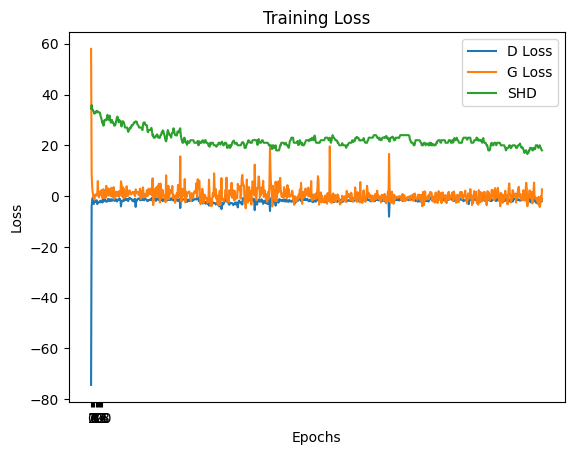

In [87]:
#DF10-01: visulize the training loss curve

# Generate a sequence of integers to represent the epoch numbers
epo = range(0, epochs)

#print("epoch", epochs.shape)
#print("D_Loss", D_Loss.shape, D_Loss)

# Plot and label the training and validation loss values
plt.plot(epo, D_Loss, label='D Loss')
plt.plot(epo, G_Loss, label='G Loss')
plt.plot(epo, S_Loss, label='SHD')

# Add in a title and axes labels
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(0, 21, 2))

# Display the plot
plt.legend(loc='best')
plt.show()


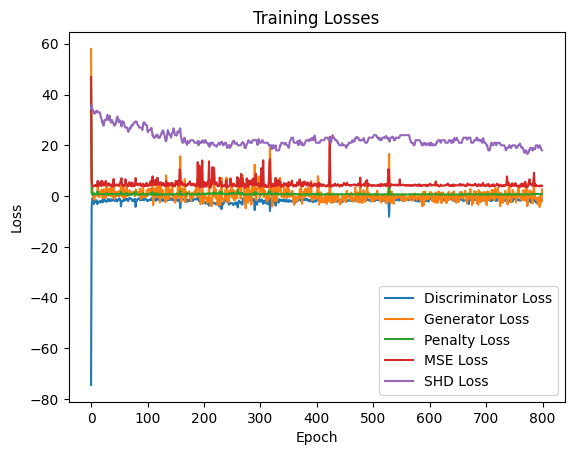

In [88]:
import matplotlib.pyplot as plt

plt.plot(D_Loss, label='Discriminator Loss')
plt.plot(G_Loss, label='Generator Loss')
plt.plot(P_Loss, label='Penalty Loss')
plt.plot(M_Loss, label='MSE Loss')
plt.plot(S_Loss, label='SHD Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()


## End <a class="anchor" id="end"></a>

* [Back to ToC](#toc)